In [1]:
reset -fs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.stats.proportion import proportions_ztest
from IPython.display import Image
%matplotlib inline

In [3]:
path = "/Users/adamszabunio/DSCI6002-student/week_8/8_2_final_project"
forest = pd.read_csv(path + "/covtype.csv")

forest.shape

(581012, 55)

In [4]:
pd.set_option("display.max_columns", forest.shape[1])
forest.columns = [col.lower() for col in forest.columns]

forest.head()

,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_distance_to_fire_points,wilderness_area1,wilderness_area2,wilderness_area3,wilderness_area4,soil_type1,soil_type2,soil_type3,soil_type4,soil_type5,soil_type6,soil_type7,soil_type8,soil_type9,soil_type10,soil_type11,soil_type12,soil_type13,soil_type14,soil_type15,soil_type16,soil_type17,soil_type18,soil_type19,soil_type20,soil_type21,soil_type22,soil_type23,soil_type24,soil_type25,soil_type26,soil_type27,soil_type28,soil_type29,soil_type30,soil_type31,soil_type32,soil_type33,soil_type34,soil_type35,soil_type36,soil_type37,soil_type38,soil_type39,soil_type40,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


# Creating subsets for selected features

In [5]:
soil = [col for col in forest.columns if "soil" in col] # 40 soil types
wilderness_types = [col for col in forest.columns if "wilderness" in col] # 40 wilderness area

continuous_features = [col for col in forest.columns if col not in soil + wilderness_types] 
continuous_features # includes the target col ("cover_type")

['elevation',
 'aspect',
 'slope',
 'horizontal_distance_to_hydrology',
 'vertical_distance_to_hydrology',
 'horizontal_distance_to_roadways',
 'hillshade_9am',
 'hillshade_noon',
 'hillshade_3pm',
 'horizontal_distance_to_fire_points',
 'cover_type']

# Create a target column for predictions (cover types)

In [6]:
target = [continuous_features.pop()] # remove "cover_type" from the continous features 
target # change to list for list wise operations later

['cover_type']

In [12]:
tree_dict = {1 : 'Spruce / Fir',
             2 : 'Lodgepole Pine',
             3 : 'Ponderosa Pine',
             4 : 'Cottonwood / Willow',
             5 : 'Aspen',
             6 : 'Douglas-fir',
             7 : 'Krummholz'}

tree_val = [v for v in tree_dict.values()] # Save Cover Type dictionary vlaues for better plotting

# From this point forward, will focus on only one tree type, Krummholz
- For Logistic Regression, it will be a One-VS-All classification problem

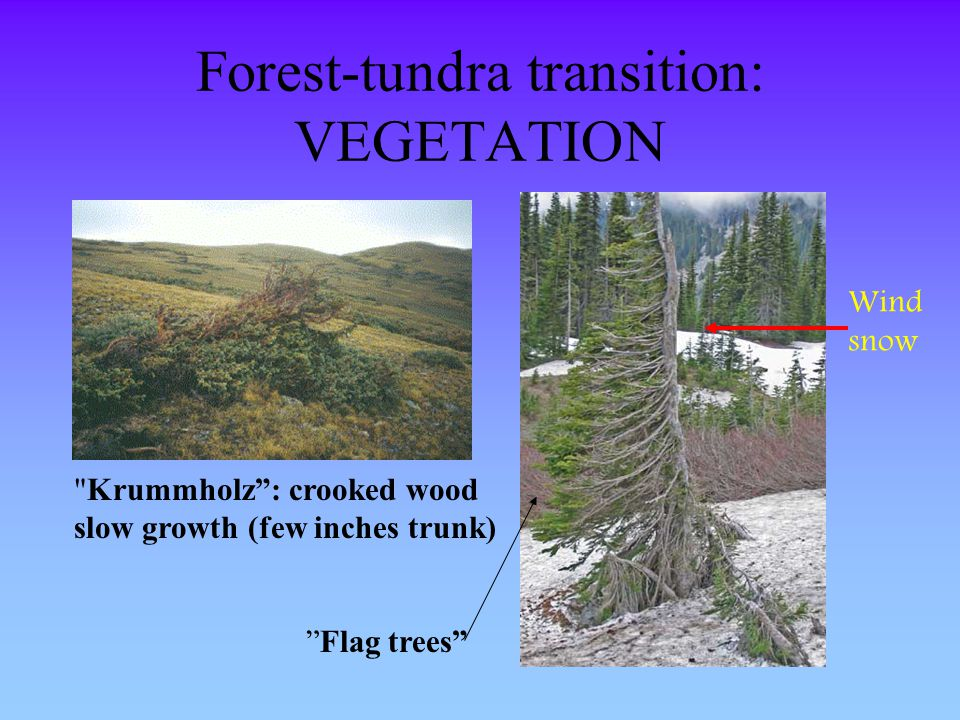

In [7]:
Image('http://slideplayer.com/slide/3570572/12/images/12/Forest-tundra+transition:+VEGETATION.jpg')

### If a tree falls in the woods... does it tell you what soil type it prefers?

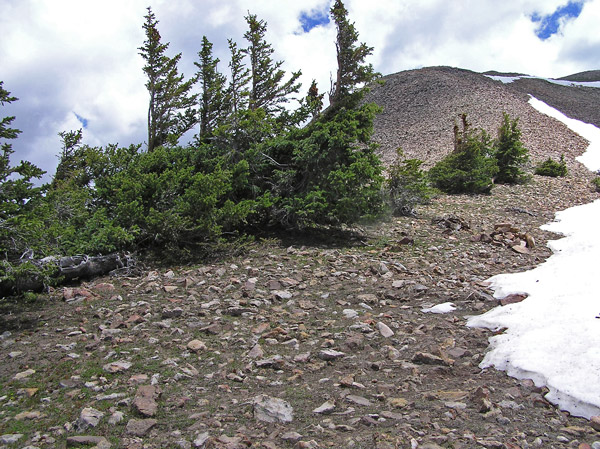

In [78]:
Image('http://www.swcoloradowildflowers.com/Tree%20Enlarged%20Photos/6pien.jpg')

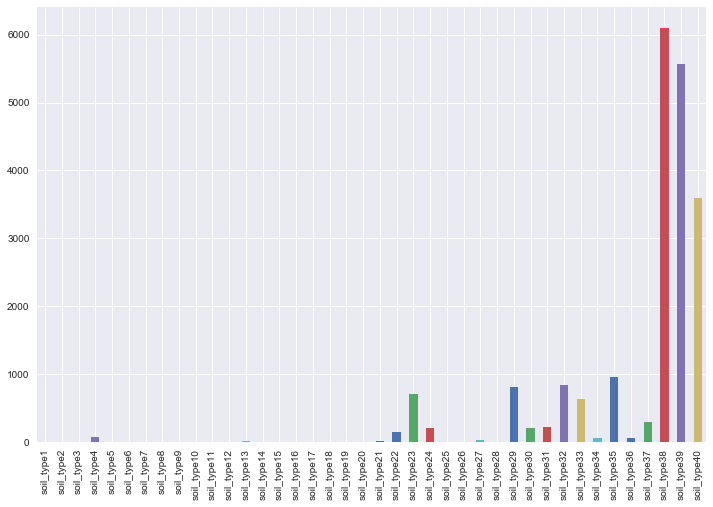

In [11]:
forest.query("cover_type == 7")[soil].sum().plot(kind="bar", figsize=(12,8));

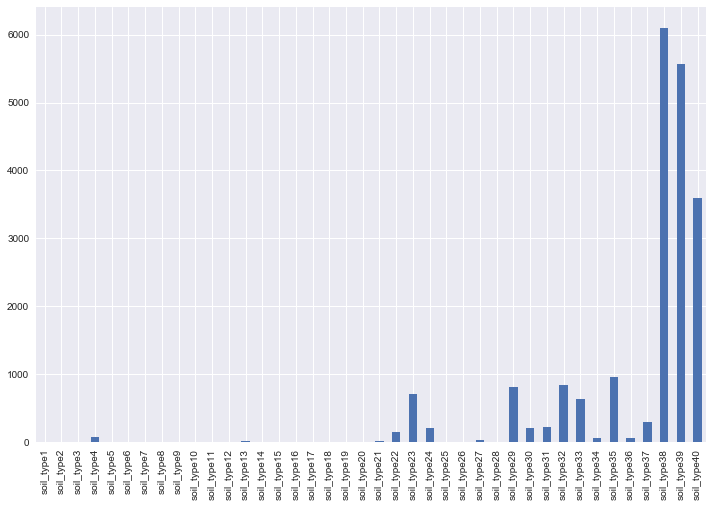

In [77]:
forest.query("cover_type == 7")[soil].sum().plot(kind="bar", figsize=(12,8));

### Clearly, Krummholz prefers soil types 38, 39 and 40. How about the other trees?

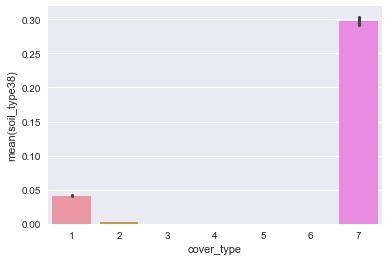

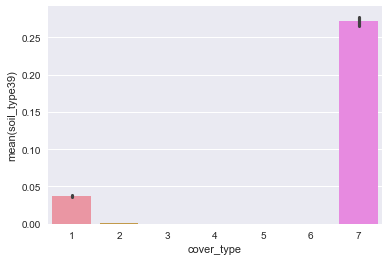

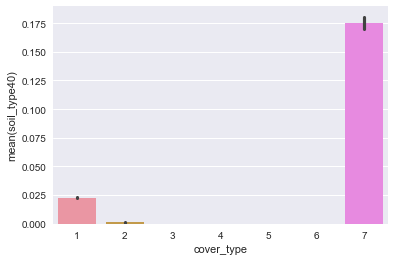

In [69]:
for col in soil[-3:]: # From above we look at just the last three soil_types
    sns.barplot(x="cover_type",y=col ,data=forest[soil+target])
    plt.show();

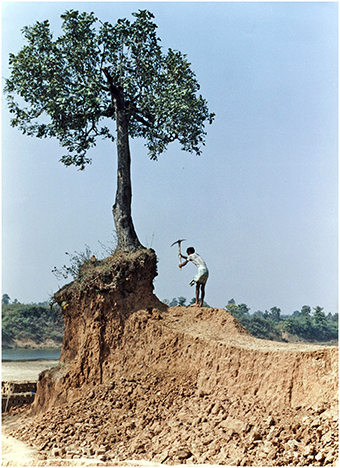

In [50]:
Image("http://www.frontiersin.org/files/Articles/180646/fenvs-04-00041-HTML/image_m/fenvs-04-00041-g005.jpg")

# Probabaility 

In [63]:
soil_type38 = forest.query("soil_type38==1")
soil_38_counts = soil_type38.cover_type.value_counts(sort=False)
prob_soil_38 = pd.DataFrame({'soil_38_counts': soil_38_counts}, index=np.arange(1,8)).replace(np.nan, 0)
prob_soil_38

,soil_38_counts
1,8729.0
2,740.0
3,0.0
4,0.0
5,0.0
6,0.0
7,6104.0


In [64]:
total_counts = [forest.cover_type.value_counts()[n] for n in range(1,8)]
#append total columns 
prob_soil_38['total_counts'] = total_counts

In [65]:
#append conditional and marginal probabilities (multiplied by 100)
prob_soil_38['soil_38_cond'] = \
            prob_soil_38.soil_38_counts.values / sum(prob_soil_38.soil_38_counts.values) *100
prob_soil_38['soil_38_joint'] = \
            [(j/total_counts[i]*100) for i,j in enumerate(prob_soil_38.soil_38_counts.values)]

# Soil type 38:  Leighcan - Moran families - Cryaquolls complex, extremely stony 


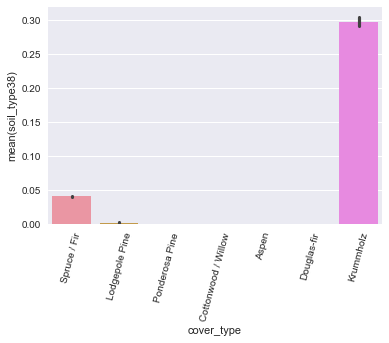

,soil_38_counts,total_counts,soil_38_cond,soil_38_joint
1,8729.0,211840,56.05,4.12
2,740.0,283301,4.75,0.26
3,0.0,35754,0.00,0.00
4,0.0,2747,0.00,0.00
5,0.0,9493,0.00,0.00
6,0.0,17367,0.00,0.00
7,6104.0,20510,39.20,29.76


In [70]:
sns.barplot(x="cover_type",y="soil_type38" ,data=forest).set_xticklabels(tree_val, rotation=75)
plt.show();
prob_soil_38.round(2)

# Soil Type 39 Moran family - Cryorthents - Leighcan family complex, extremely stony

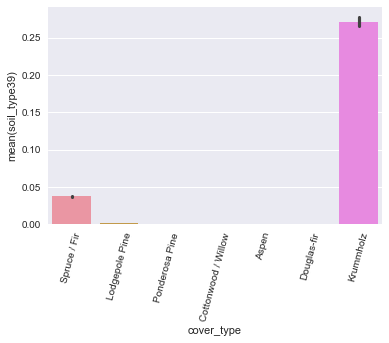

,soil_39_counts,total_counts,soil_39_cond,soil_39_joint
1,7882.0,211840,57.09,3.72
2,358.0,283301,2.59,0.13
3,0.0,35754,0.00,0.00
4,0.0,2747,0.00,0.00
5,0.0,9493,0.00,0.00
6,0.0,17367,0.00,0.00
7,5566.0,20510,40.32,27.14


In [88]:
soil_39 = forest.query("soil_type39 ==1")
soil_39.cover_type.value_counts(sort=False)
soil_39_counts = soil_39.cover_type.value_counts(sort=False)
prob_soil_39 = pd.DataFrame({'soil_39_counts': soil_39_counts}, index=np.arange(1,8)).replace(np.nan, 0)

#append total columns 
prob_soil_39['total_counts'] = total_counts

#append conditional and marginal probabilities (multiplied by 100)
prob_soil_39['soil_39_cond'] = \
            prob_soil_39.soil_39_counts.values / sum(prob_soil_39.soil_39_counts.values) *100
prob_soil_39['soil_39_joint'] = \
            [(j/total_counts[i]*100) for i,j in enumerate(prob_soil_39.soil_39_counts.values)]

sns.barplot(x="cover_type",y="soil_type39" ,data=forest).set_xticklabels(tree_val, rotation=75)
plt.show();
prob_soil_39.round(2)

# Soil Type 40 Moran family - Cryorthents - Rock land complex, extremely stony

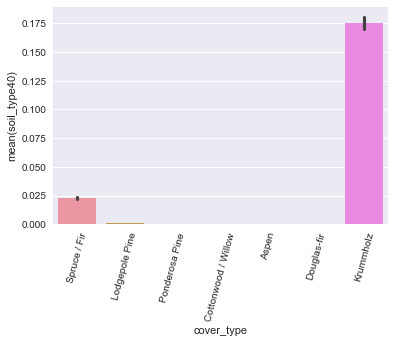

,soil_40_counts,total_counts,soil_40_cond,soil_40_joint
1,4826.0,211840,55.15,2.28
2,332.0,283301,3.79,0.12
3,0.0,35754,0.00,0.00
4,0.0,2747,0.00,0.00
5,0.0,9493,0.00,0.00
6,0.0,17367,0.00,0.00
7,3592.0,20510,41.05,17.51


In [87]:
soil_40 = forest.query("soil_type40 ==1")
soil_40.cover_type.value_counts(sort=False)
soil_40_counts = soil_40.cover_type.value_counts(sort=False)
prob_soil_40 = pd.DataFrame({'soil_40_counts': soil_40_counts}, index=np.arange(1,8)).replace(np.nan, 0)

#append total columns 
prob_soil_40['total_counts'] = total_counts

#append conditional and marginal probabilities (multiplied by 100)
prob_soil_40['soil_40_cond'] = \
            prob_soil_40.soil_40_counts.values / sum(prob_soil_40.soil_40_counts.values) *100
prob_soil_40['soil_40_joint'] = \
            [(j/total_counts[i]*100) for i,j in enumerate(prob_soil_40.soil_40_counts.values)]

sns.barplot(x="cover_type",y="soil_type40" ,data=forest).set_xticklabels(tree_val, rotation=75)
plt.show();
prob_soil_40.round(2)

In [89]:
print("Precentage of all the Krummholz trees in this dataset that were found in only the Moran Family Soil Type = {:.2f}%"\
      .format(prob_soil_38.soil_38_joint[7]+prob_soil_39.soil_39_joint[7]+prob_soil_39.soil_39_joint[7]))

Precentage of all the Krummholz trees in this dataset that were found in only the Moran Family Soil Type = 84.04%


# Models
## First lets One Hot Encode the target (cover_types) column

In [31]:
forest_dummies = forest.copy()
dummy_trees = pd.get_dummies(forest_dummies['cover_type'], prefix='tree')

dummy_trees.head()

,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7
0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0


In [32]:
forest_dummies = forest_dummies.join(dummy_trees["tree_7"])
forest_dummies.head()

,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_distance_to_fire_points,wilderness_area1,wilderness_area2,wilderness_area3,wilderness_area4,soil_type1,soil_type2,soil_type3,soil_type4,soil_type5,soil_type6,soil_type7,soil_type8,soil_type9,soil_type10,soil_type11,soil_type12,soil_type13,...,soil_type16,soil_type17,soil_type18,soil_type19,soil_type20,soil_type21,soil_type22,soil_type23,soil_type24,soil_type25,soil_type26,soil_type27,soil_type28,soil_type29,soil_type30,soil_type31,soil_type32,soil_type33,soil_type34,soil_type35,soil_type36,soil_type37,soil_type38,soil_type39,soil_type40,cover_type,tree_7
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5,0


In [33]:
def model(n):
    model = 'tree_' + str(n) + ' ~ ' 
    for col in continuous_features:
        if col == "horizontal_distance_to_fire_points":
            model = model + str(col)
        else:
            model = model + str(col) + " + "
    return model 

print(model(7))

tree_7 ~ elevation + aspect + slope + horizontal_distance_to_hydrology + vertical_distance_to_hydrology + horizontal_distance_to_roadways + hillshade_9am + hillshade_noon + hillshade_3pm + horizontal_distance_to_fire_points


In [34]:
logit_continuous = smf.logit(formula=model(7), data=forest_dummies).fit()
logit_continuous.summary()

Optimization terminated successfully.
         Current function value: 0.079204
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 tree_7   No. Observations:               581012
Model:                          Logit   Df Residuals:                   581001
Method:                           MLE   Df Model:                           10
Date:                Sun, 03 Dec 2017   Pseudo R-squ.:                  0.4813
Time:                        21:39:16   Log-Likelihood:                -46018.
converged:                       True   LL-Null:                       -88726.
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Intercept                            -57.1024      0.516   -110.758      0.000       -58.113   -56.092
elevation                              0.0179      0.000    172.320      0.000         0.018     0.018
aspect                                 0.0014      0.000     12.685      0.000         0.001     0.002
slope                                 -0.0232      0.002     -9.618      0.000        -0.028    -0.018
horizontal_distance_to_hydrology      -0.0014   5.19e-05    -26.830      0.000        -0.001    -0.001
vertical_distance_to_hydrology        -0.0037      0.000    -18.657      0.000        -0.004    -0.003
horizontal_distance_to_roadways     5.257e-05   6.38e-06      8.239      0.000      4.01e-05  6.51e-05
hillshade_9am                         -0.0072      0.002     -3.166      0.002        -0.012    -0.003
hillshade_noon                         0.0027      0.002      1.424      0.154        -0.001     0.006
hillshade_3pm                         -0.0176      0.002     -9.639      0.000        -0.021    -0.014
horizontal_distance_to_fire_points  7.089e-05   8.18e-06      8.668      0.000      5.49e-05  8.69e-05
======================================================================================================

Possibly complete quasi-separation: A fraction 0.33 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [35]:
logit_continuous.fittedvalues.describe()

count    581012.000000
mean         -7.914147
std           4.983270
min         -27.558570
25%         -10.524122
50%          -7.238001
75%          -4.275264
max           7.749565
dtype: float64

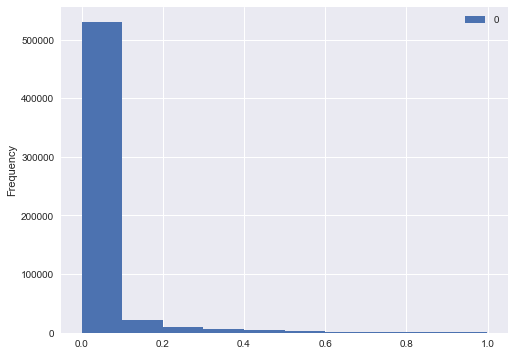

In [36]:
probabilities = pd.DataFrame(logit_continuous.predict())
probabilities.plot(kind="hist", figsize=(8,6));

In [37]:
probabilities["preds"] = probabilities[0].apply(lambda x: 0 if x < 0.5 else 1)
probabilities.head()

,0,preds
0,7.835916e-07,0
1,7.537594e-07,0
2,3.306129e-05,0
3,2.042493e-05,0
4,8.747840e-07,0


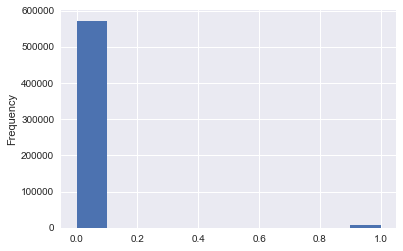

In [39]:
probabilities["preds"].plot(kind="hist");

In [40]:
logit_continuous.pred_table()

array([[ 556900.,    3602.],
       [  15061.,    5449.]])

In [41]:
select_formula = 'tree_7 ~ C(soil_type38) + C(soil_type39) + C(soil_type40) + C(wilderness_area3)'
logit_select = smf.logit(formula=select_formula, data=forest_dummies).fit()
logit_select.summary()

Optimization terminated successfully.
         Current function value: 0.088524
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 tree_7   No. Observations:               581012
Model:                          Logit   Df Residuals:                   581007
Method:                           MLE   Df Model:                            4
Date:                Sun, 03 Dec 2017   Pseudo R-squ.:                  0.4203
Time:                        21:40:07   Log-Likelihood:                -51433.
converged:                       True   LL-Null:                       -88726.
                                        LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
Intercept           -5.6034      0.020   -274.307      0.000        -5.643    -5.563
soil_type38          4.5136      0.023    192.984      0.000         4.468     4.559
soil_type39          4.4656      0.024    187.223      0.000         4.419     4.512
soil_type40          4.8141      0.029    167.817      0.000         4.758     4.870
wilderness_area3     1.5633      0.019     82.010      0.000         1.526     1.601
====================================================================================
"""

In [42]:
logit_select.pred_table()

array([[ 555939.,    4563.],
       [  10654.,    9856.]])

In [45]:
three_soil_wilderness3 = "+ C(soil_type38) + C(soil_type39) + C(soil_type40) + C(wilderness_area3)"
model_with_categorical = model(7)+ three_soil_wilderness3
logit_with_categorical = smf.logit(formula=model_with_categorical, data=forest_dummies).fit()

logit_with_categorical.summary()

Optimization terminated successfully.
         Current function value: 0.063219
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 tree_7   No. Observations:               581012
Model:                          Logit   Df Residuals:                   580997
Method:                           MLE   Df Model:                           14
Date:                Sun, 03 Dec 2017   Pseudo R-squ.:                  0.5860
Time:                        21:47:47   Log-Likelihood:                -36731.
converged:                       True   LL-Null:                       -88726.
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Intercept                            -49.9245      0.553    -90.220      0.000       -51.009   -48.840
C(soil_type38)[T.1]                    2.2599      0.028     79.780      0.000         2.204     2.315
C(soil_type39)[T.1]                    2.5428      0.029     86.296      0.000         2.485     2.601
C(soil_type40)[T.1]                    1.4438      0.040     35.763      0.000         1.365     1.523
C(wilderness_area3)[T.1]               2.0861      0.024     88.591      0.000         2.040     2.132
elevation                              0.0150      0.000    121.354      0.000         0.015     0.015
aspect                                 0.0003      0.000      2.591      0.010      7.97e-05     0.001
slope                                 -0.0374      0.003    -14.225      0.000        -0.043    -0.032
horizontal_distance_to_hydrology      -0.0020   5.86e-05    -34.479      0.000        -0.002    -0.002
vertical_distance_to_hydrology        -0.0019      0.000     -8.536      0.000        -0.002    -0.001
horizontal_distance_to_roadways    -4.201e-05   8.38e-06     -5.015      0.000     -5.84e-05 -2.56e-05
hillshade_9am                         -0.0078      0.002     -3.454      0.001        -0.012    -0.003
hillshade_noon                         0.0059      0.002      3.084      0.002         0.002     0.010
hillshade_3pm                         -0.0190      0.002    -10.567      0.000        -0.023    -0.016
horizontal_distance_to_fire_points     0.0003   9.76e-06     32.492      0.000         0.000     0.000
======================================================================================================

Possibly complete quasi-separation: A fraction 0.33 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [47]:
logit_with_categorical.pred_table()

array([[ 556679.,    3823.],
       [   9982.,   10528.]])

### Pseudo R-Squared for all three models 

In [49]:
logit_continuous.prsquared, logit_select.prsquared, logit_with_categorical.prsquared

(0.48134278439730105, 0.42031441745550679, 0.58601559043417395)

In [86]:
'''
Borrowed from: https://github.com/statsmodels/statsmodels/issues/1577, 
Modified from: 
tp, fp, fn, tn = map(float, pred_table.flatten())
To: 
tn, fn, fp, tp = map(float, pred_table.flatten())
'''
def precision(pred_table):
    """
    Precision given pred_table. Binary classification only. Assumes group 0 # Stats_models default (opposite day)
    is the True.

    Analagous to (absence of) Type I errors. Probability that a randomly
    selected document is classified correctly. I.e., no false negatives.
    """
    tn, fn, fp, tp = map(float, pred_table.flatten())
    return tp / (tp + fp)


def recall(pred_table):
    """
    Precision given pred_table. Binary classification only. Assumes group 0 # Same problem as above
    is the True.

    Analagous to (absence of) Type II errors. Out of all the ones that are
    true, how many did you predict as true. I.e., no false positives.
    """
    tn, fn, fp, tp = map(float, pred_table.flatten())
    try:
        return tp / (tp + fn)
    except ZeroDivisionError:
        return np.nan


def accuracy(pred_table):
    """
    Precision given pred_table. Binary classification only. Assumes group 0 # Look above
    is the True.
    """
    tn, fn, fp, tp = map(float, pred_table.flatten())
    return (tp + tn) / (tp + tn + fp + fn)


def fscore_measure(pred_table, b=1):
    """
    For b, 1 = equal importance. 2 = recall is twice important. .5 recall is
    half as important, etc.
    """
    r = recall(pred_table)
    p = precision(pred_table)
    try:
        return (1 + b**2) * r*p/(b**2 * p + r)
    except ZeroDivisionError:
        return np.nan

In [96]:
confusion_matricies = {"Continuous Features": logit_continuous.pred_table(), 
                       "Select Categorical Features": logit_select.pred_table(), 
                       "Continuous and Select Categorical Features": logit_with_categorical.pred_table()}

for k, v in confusion_matricies.items():
    heading = k +" Logistic Regression:"
    print(heading)
    print("-"*len(heading))
    print("Precision: {:.4f}\n".format(precision(v)))
    print("Recall: {:.4f}\n".format(recall(v)))
    print("Accuracy: {:.4f}\n".format(accuracy(v)))
    print("F1 score: {:.4f}".format(fscore_measure(v)))
    print("-"*len(heading) +"\n")

Continuous Features Logistic Regression:
----------------------------------------
Precision: 0.2657

Recall: 0.6020

Accuracy: 0.9679

F1 score: 0.3687
----------------------------------------

Select Categorical Features Logistic Regression:
------------------------------------------------
Precision: 0.4805

Recall: 0.6835

Accuracy: 0.9738

F1 score: 0.5643
------------------------------------------------

Continuous and Select Categorical Features Logistic Regression:
---------------------------------------------------------------
Precision: 0.5133

Recall: 0.7336

Accuracy: 0.9762

F1 score: 0.6040
---------------------------------------------------------------



### Interpretations of Results above:
- All models have very high accuracy, however this is a terrible measure as the accuracy is highly skewed by the massive class imbalances
- Model with only continuous features has the lowest precision. Much lower than 4 categorical features (albeit these were handpicked after extensive EDA)
- Not surprisingly the model with a combination of categorical and continuous features outpreforms the individual models. 
### Need to standarize Features!
- Below, when we try and fit the model with all features, we run into errors (even if the faetures are regularized) 

### NOTE: statsmodel assumes "0" to be true and "1" to be False

In [79]:
test = forest_dummies.copy()
test.tree_7 = test.tree_7.apply(lambda x: 1 if x == 0 else 0)

logit_test = smf.logit(formula=model(7), data=test).fit()
logit_test.summary()

Optimization terminated successfully.
         Current function value: 0.079204
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 tree_7   No. Observations:               581012
Model:                          Logit   Df Residuals:                   581001
Method:                           MLE   Df Model:                           10
Date:                Mon, 04 Dec 2017   Pseudo R-squ.:                  0.4813
Time:                        10:13:34   Log-Likelihood:                -46018.
converged:                       True   LL-Null:                       -88726.
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Intercept                             57.1024      0.516    110.758      0.000        56.092    58.113
elevation                             -0.0179      0.000   -172.320      0.000        -0.018    -0.018
aspect                                -0.0014      0.000    -12.685      0.000        -0.002    -0.001
slope                                  0.0232      0.002      9.618      0.000         0.018     0.028
horizontal_distance_to_hydrology       0.0014   5.19e-05     26.830      0.000         0.001     0.001
vertical_distance_to_hydrology         0.0037      0.000     18.657      0.000         0.003     0.004
horizontal_distance_to_roadways    -5.257e-05   6.38e-06     -8.239      0.000     -6.51e-05 -4.01e-05
hillshade_9am                          0.0072      0.002      3.166      0.002         0.003     0.012
hillshade_noon                        -0.0027      0.002     -1.424      0.154        -0.006     0.001
hillshade_3pm                          0.0176      0.002      9.639      0.000         0.014     0.021
horizontal_distance_to_fire_points -7.089e-05   8.18e-06     -8.668      0.000     -8.69e-05 -5.49e-05
======================================================================================================

Possibly complete quasi-separation: A fraction 0.33 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### Results are exactly the same as when "1" is true and "0" is False. Only the interpretation of the confusion matrix needs to be modified

In [80]:
logit_test.pred_table() # with the assumption of the confusion matrix is in the "typical" form: tp and tn along the diagonals

array([[   5449.,   15061.],
       [   3602.,  556900.]])

### Lets try and fit the entire model (all features) 

In [50]:
def categorize(var):
    return "C(" + var + ")"

all_feats = continuous_features + [categorize(f) for f in wilderness_types] + [categorize(f) for f in soil]

In [52]:
def full_model(n):
    model = 'tree_' + str(n) + ' ~ ' 
    for col in all_feats:
        if col == "C(soil_type40)":
            model = model + str(col)
        else:
            model = model + str(col) + " + "
    return model 
full_model(7)

'tree_7 ~ elevation + aspect + slope + horizontal_distance_to_hydrology + vertical_distance_to_hydrology + horizontal_distance_to_roadways + hillshade_9am + hillshade_noon + hillshade_3pm + horizontal_distance_to_fire_points + C(wilderness_area1) + C(wilderness_area2) + C(wilderness_area3) + C(wilderness_area4) + C(soil_type1) + C(soil_type2) + C(soil_type3) + C(soil_type4) + C(soil_type5) + C(soil_type6) + C(soil_type7) + C(soil_type8) + C(soil_type9) + C(soil_type10) + C(soil_type11) + C(soil_type12) + C(soil_type13) + C(soil_type14) + C(soil_type15) + C(soil_type16) + C(soil_type17) + C(soil_type18) + C(soil_type19) + C(soil_type20) + C(soil_type21) + C(soil_type22) + C(soil_type23) + C(soil_type24) + C(soil_type25) + C(soil_type26) + C(soil_type27) + C(soil_type28) + C(soil_type29) + C(soil_type30) + C(soil_type31) + C(soil_type32) + C(soil_type33) + C(soil_type34) + C(soil_type35) + C(soil_type36) + C(soil_type37) + C(soil_type38) + C(soil_type39) + C(soil_type40)'

In [63]:
full_logit = smf.logit(formula=full_model(7), data=forest_dummies).fit(maxiter=100)
full_logit.summary()

         Current function value: 0.057636
         Iterations: 100


/Users/adamszabunio/anaconda/envs/stats/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/adamszabunio/anaconda/envs/stats/lib/python3.6/site-packages/statsmodels/base/model.py:971: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))
/Users/adamszabunio/anaconda/envs/stats/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/adamszabunio/anaconda/envs/stats/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/adamszabunio/anaconda/envs/stats/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = 

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 tree_7   No. Observations:               581012
Model:                          Logit   Df Residuals:                   580959
Method:                           MLE   Df Model:                           52
Date:                Sun, 03 Dec 2017   Pseudo R-squ.:                  0.6226
Time:                        23:01:42   Log-Likelihood:                -33487.
converged:                      False   LL-Null:                       -88726.
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Intercept                            -41.9959   3.02e+05     -0.000      1.000     -5.91e+05  5.91e+05
C(wilderness_area1)[T.1]             -28.8093        nan        nan        nan           nan       nan
C(wilderness_area2)[T.1]             -28.6965        nan        nan        nan           nan       nan
C(wilderness_area3)[T.1]             -25.9676        nan        nan        nan           nan       nan
C(wilderness_area4)[T.1]             -38.4613        nan        nan        nan           nan       nan
C(soil_type1)[T.1]                    -2.1209   1.53e+09  -1.39e-09      1.000        -3e+09     3e+09
C(soil_type2)[T.1]                    -4.8582   5.97e+05  -8.14e-06      1.000     -1.17e+06  1.17e+06
C(soil_type3)[T.1]                    -7.7603   8.26e+06   -9.4e-07      1.000     -1.62e+07  1.62e+07
C(soil_type4)[T.1]                    24.6602        nan        nan        nan           nan       nan
C(soil_type5)[T.1]                   -14.6953   7.75e+11   -1.9e-11      1.000     -1.52e+12  1.52e+12
C(soil_type6)[T.1]                    -1.1557   2.64e+08  -4.38e-09      1.000     -5.17e+08  5.17e+08
C(soil_type7)[T.1]                   -27.4827   1.71e+11  -1.61e-10      1.000     -3.35e+11  3.35e+11
C(soil_type8)[T.1]                    -5.1859   1.73e+06  -2.99e-06      1.000      -3.4e+06   3.4e+06
C(soil_type9)[T.1]                    -1.1314   1.63e+06  -6.94e-07      1.000      -3.2e+06   3.2e+06
C(soil_type10)[T.1]                   -9.4965   2.01e+06  -4.73e-06      1.000     -3.94e+06  3.94e+06
C(soil_type11)[T.1]                  -22.6376   1.26e+09  -1.79e-08      1.000     -2.48e+09  2.48e+09
C(soil_type12)[T.1]                  -19.1050    1.9e+08  -1.01e-07      1.000     -3.72e+08  3.72e+08
C(soil_type13)[T.1]                   17.2343        nan        nan        nan           nan       nan
C(soil_type14)[T.1]                   -3.2044   1.15e+07  -2.78e-07      1.000     -2.26e+07  2.26e+07
C(soil_type15)[T.1]                  -20.4300   3.24e+15   -6.3e-15      1.000     -6.35e+15  6.35e+15
C(soil_type16)[T.1]                  -18.7462   1.88e+08  -9.96e-08      1.000     -3.69e+08  3.69e+08
C(soil_type17)[T.1]                   -7.1851   8.05e+05  -8.93e-06      1.000     -1.58e+06  1.58e+06
C(soil_type18)[T.1]                  -19.6365   7.02e+08   -2.8e-08      1.000     -1.38e+09  1.38e+09
C(soil_type19)[T.1]                   18.3627        nan        nan        nan           nan       nan
C(soil_type20)[T.1]                 -265.6563   3.47e+61  -7.65e-60      1.000     -6.81e+61  6.81e+61
C(soil_type21)[T.1]                   18.4955        nan        nan        nan           nan       nan
C(soil_type22)[T.1]                   18.4918        nan        nan        nan           nan       nan
C(soil_type23)[T.1]                   19.3825        nan        nan        nan           nan       nan
C(soil_type24)[T.1]                   19.0851   

### Not even regularization (L1) helps. Features need to be scaled appropriately. OR we can choose a model that can handle a mix of features. Time to move on.

In [64]:
full_logit = smf.logit(formula=full_model(7), data=forest_dummies).fit_regularized()
full_logit.summary()

/Users/adamszabunio/anaconda/envs/stats/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1213: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/adamszabunio/anaconda/envs/stats/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:1263: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0576449593321
            Iterations: 346
            Function evaluations: 376
            Gradient evaluations: 346


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 tree_7   No. Observations:               581012
Model:                          Logit   Df Residuals:                   580957
Method:                           MLE   Df Model:                           54
Date:                Sun, 03 Dec 2017   Pseudo R-squ.:                  0.6225
Time:                        23:04:59   Log-Likelihood:                -33492.
converged:                       True   LL-Null:                       -88726.
                                        LLR p-value:                     0.000
======================================================================================================
                                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------------
Intercept                            -37.6646   3.15e+05     -0.000      1.000     -6.17e+05  6.17e+05
C(wilderness_area1)[T.1]             -10.9409   4.32e+05  -2.54e-05      1.000     -8.46e+05  8.46e+05
C(wilderness_area2)[T.1]             -10.8312   4.32e+05  -2.51e-05      1.000     -8.47e+05  8.47e+05
C(wilderness_area3)[T.1]              -8.0973   4.32e+05  -1.88e-05      1.000     -8.46e+05  8.46e+05
C(wilderness_area4)[T.1]              -7.7173   4.33e+05  -1.78e-05      1.000     -8.48e+05  8.48e+05
C(soil_type1)[T.1]                    -1.0187   4.57e+05  -2.23e-06      1.000     -8.96e+05  8.96e+05
C(soil_type2)[T.1]                    -1.2839   4.57e+05  -2.81e-06      1.000     -8.96e+05  8.96e+05
C(soil_type3)[T.1]                    -0.2031   4.57e+05  -4.44e-07      1.000     -8.96e+05  8.96e+05
C(soil_type4)[T.1]                     2.3125   4.57e+05   5.06e-06      1.000     -8.96e+05  8.96e+05
C(soil_type5)[T.1]                    -0.1088   4.57e+05  -2.38e-07      1.000     -8.96e+05  8.96e+05
C(soil_type6)[T.1]                     0.1989   4.57e+05   4.35e-07      1.000     -8.96e+05  8.96e+05
C(soil_type7)[T.1]                    -0.1545   4.57e+05  -3.38e-07      1.000     -8.96e+05  8.96e+05
C(soil_type8)[T.1]                    -0.3288   4.57e+05  -7.19e-07      1.000     -8.96e+05  8.96e+05
C(soil_type9)[T.1]                    -0.0177   4.57e+05  -3.88e-08      1.000     -8.96e+05  8.96e+05
C(soil_type10)[T.1]                   -4.6398   4.57e+05  -1.01e-05      1.000     -8.96e+05  8.96e+05
C(soil_type11)[T.1]                   -3.3935   4.57e+05  -7.42e-06      1.000     -8.96e+05  8.96e+05
C(soil_type12)[T.1]                   -5.5620   4.57e+05  -1.22e-05      1.000     -8.96e+05  8.96e+05
C(soil_type13)[T.1]                   -5.2833   4.57e+05  -1.16e-05      1.000     -8.96e+05  8.96e+05
C(soil_type14)[T.1]                   -0.0174   4.57e+05  -3.81e-08      1.000     -8.96e+05  8.96e+05
C(soil_type15)[T.1]                -3.825e-05   4.57e+05  -8.36e-11      1.000     -8.96e+05  8.96e+05
C(soil_type16)[T.1]                   -3.4752   4.57e+05   -7.6e-06      1.000     -8.96e+05  8.96e+05
C(soil_type17)[T.1]                   -3.1400   4.57e+05  -6.87e-06      1.000     -8.96e+05  8.96e+05
C(soil_type18)[T.1]                   -1.9523   4.57e+05  -4.27e-06      1.000     -8.96e+05  8.96e+05
C(soil_type19)[T.1]                   -3.4210   4.57e+05  -7.48e-06      1.000     -8.96e+05  8.96e+05
C(soil_type20)[T.1]                   -7.9222   4.57e+05  -1.73e-05      1.000     -8.96e+05  8.96e+05
C(soil_type21)[T.1]                   -3.8791   4.57e+05  -8.48e-06      1.000     -8.96e+05  8.96e+05
C(soil_type22)[T.1]                   -3.8597   4.57e+05  -8.44e-06      1.000     -8.96e+05  8.96e+05
C(soil_type23)[T.1]                   -2.9651   4.57e+05  -6.48e-06      1.000     -8.96e+05  8.96e+05
C(soil_type24)[T.1]                   -3.2618   

____